In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from superres import *
from scipy.ndimage.interpolation import zoom as npzoom
from skimage.util import img_as_float32
from skimage.measure import compare_ssim, compare_psnr

In [4]:
img_data = Path('/scratch/bpho/datasets/emsynth_002/')
model_path = Path('/scratch/bpho/models')

In [5]:
def get_src():
    hr_tifs = img_data/f'hr'
    lr_tifs = img_data/f'lr_up'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src


def get_data(bs, size, noise=None, max_zoom=1.1):
    src = get_src()
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [6]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [7]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [8]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [9]:
bs = 64
size = 128
data = get_data(bs, size, max_zoom=6)
data

/scratch/bpho/datasets/emsynth_002/lr_up


ImageDataBunch;

Train: LabelList (1728 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/emsynth_002/lr_up;

Valid: LabelList (432 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/emsynth_002/lr_up;

Test: None

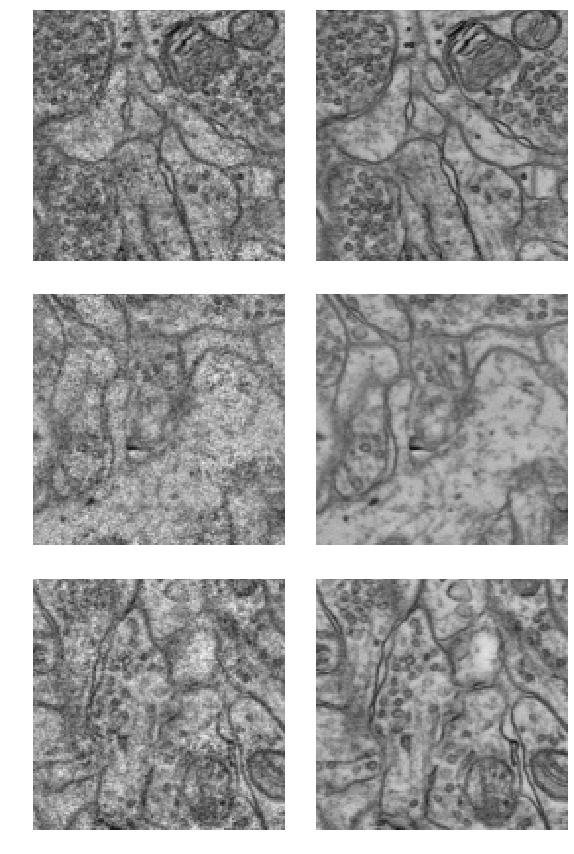

In [10]:
data.show_batch(3, ds_type=DatasetType.Valid)

In [11]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

11922

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


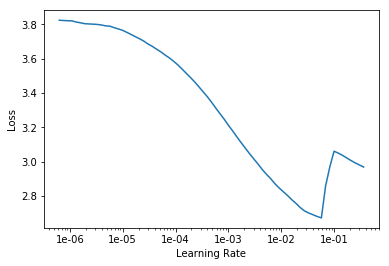

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
lr = 1e-3

In [14]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.214598,1.792121,0.051283,0.595341,12.902340,0.179497,0.197439,0.234631,0.064561,0.453718,0.602200,0.060075,00:19
1,1.909936,1.558306,0.045750,0.626809,13.398500,0.170003,0.186633,0.221039,0.061287,0.335041,0.527113,0.057190,00:18
2,1.776461,1.473223,0.040380,0.652288,13.939857,0.158626,0.183245,0.216897,0.060517,0.294827,0.502333,0.056778,00:18
3,1.711160,1.464595,0.041557,0.643224,13.814848,0.160188,0.185211,0.217638,0.060596,0.288271,0.496017,0.056674,00:18
4,1.658599,1.403011,0.038492,0.670735,14.147362,0.154520,0.184143,0.214236,0.059164,0.258829,0.476371,0.055748,00:18
5,1.713753,1.635197,0.049670,0.632172,13.043197,0.177155,0.190322,0.225613,0.064841,0.356914,0.559080,0.061272,00:18
6,1.847530,1.467325,0.041176,0.660605,13.855354,0.161070,0.182548,0.218258,0.060621,0.286042,0.502226,0.056559,00:18
7,1.772660,1.441091,0.040603,0.652997,13.916274,0.159103,0.184476,0.216617,0.059296,0.275784,0.490231,0.055583,00:18
8,1.704394,1.415437,0.038722,0.668786,14.121696,0.154970,0.184032,0.214877,0.058354,0.266005,0.482512,0.054686,00:18
9,1.655070,1.406694,0.038741,0.668187,14.119530,0.155161,0.183170,0.214057,0.058856,0.262045,0.478262,0.055142,00:18


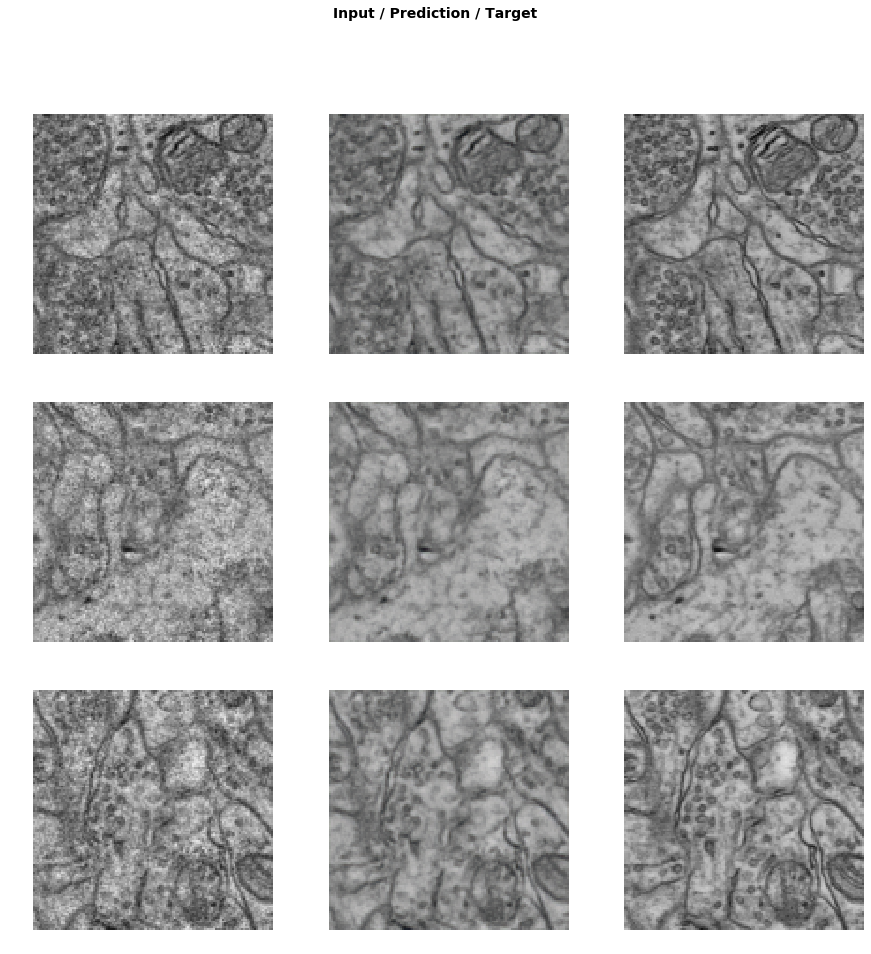

In [15]:
do_fit('emsynth_002_unet.0', slice(lr*10))

In [16]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.520067,1.352464,0.037415,0.675681,14.270399,0.151895,0.182241,0.210508,0.057182,0.239428,0.457134,0.054076,00:18
1,1.515415,1.351072,0.037220,0.675379,14.293188,0.151340,0.182374,0.210243,0.057073,0.239089,0.456997,0.053956,00:18
2,1.508951,1.349599,0.037201,0.675517,14.295345,0.151370,0.182237,0.210149,0.057275,0.238346,0.456003,0.054219,00:18
3,1.506674,1.357336,0.037181,0.673556,14.297668,0.151086,0.182461,0.210008,0.057235,0.243867,0.458531,0.054147,00:18
4,1.502214,1.339498,0.037320,0.677212,14.281427,0.151492,0.181588,0.209587,0.057088,0.232583,0.453006,0.054154,00:18
5,1.502208,1.349676,0.037047,0.679093,14.313251,0.150863,0.181748,0.209542,0.056941,0.240635,0.455935,0.054011,00:18
6,1.504231,1.358109,0.037127,0.674954,14.304011,0.151256,0.182184,0.209564,0.056684,0.245314,0.459601,0.053507,00:18
7,1.502291,1.341607,0.036698,0.678238,14.354505,0.150059,0.181128,0.209134,0.056977,0.236381,0.453865,0.054063,00:18
8,1.503589,1.345071,0.036951,0.678852,14.324623,0.150800,0.181392,0.208669,0.056539,0.241385,0.452740,0.053546,00:18
9,1.502628,1.331811,0.036807,0.677572,14.341669,0.150668,0.181164,0.207880,0.056165,0.232272,0.450438,0.053223,00:18


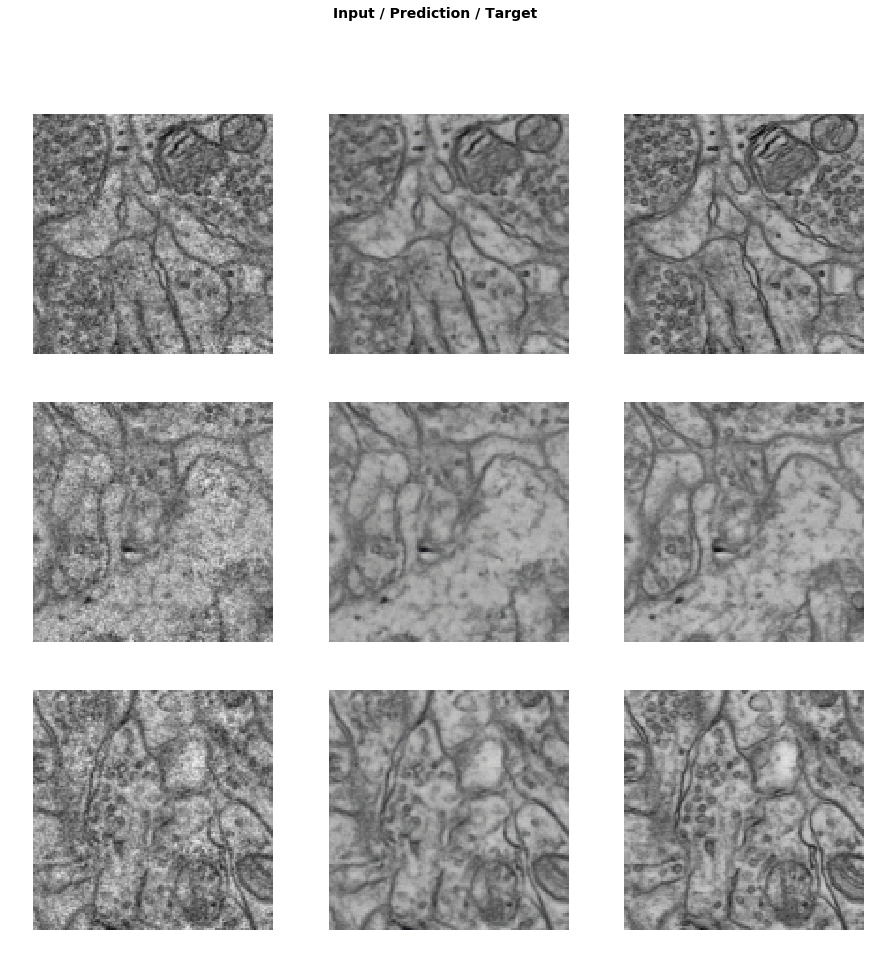

In [18]:
do_fit('emsynth_002_unet.1', slice(1e-5,lr))

In [ ]:
bs = 32
size = 256
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_002_unet.1')

In [ ]:
do_fit('emsynth_002_unet.2', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_002_unet.3', slice(1e-5,lr))

In [ ]:
bs = 4
size = 512
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_002_unet.3')

In [ ]:
do_fit('emsynth_002_unet.4', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_002_unet.5', slice(1e-5,lr), cycle_len=10)

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_002_unet.5')

In [ ]:
do_fit('emsynth_002_unet.6', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_002_unet.7', slice(1e-5,lr), cycle_len=10)

In [ ]:
bs = 1
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_002_unet.6').to_fp16()

In [ ]:
learn.unfreeze()
do_fit('emsynth_002_unet.8', slice(1e-6,1e-5), cycle_len=10)

In [ ]:
do_fit('emsynth_002_unet.9', slice(1e-6,1e-5), cycle_len=1)

In [ ]:
!ls /scratch/bpho/models

In [ ]:
bs = 1
size = 1920
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_002_unet.8')

In [ ]:
test_files = Path('/scratch/bpho/datasources/EM_manually_aquired_pairs_01242019/')
test_hr = list((test_files/'aligned_hr').glob('*.tif'))
test_lr = list((test_files/'aligned_lr').glob('*.tif'))
results = Path('/scratch/bpho/results/emsynth_002')

if results.exists(): shutil.rmtree(results)
results.mkdir(parents=True, mode=0o775, exist_ok=True)

def get_key(fn):
    return fn.stem[0:(fn.stem.find('Region')-1)]

hr_map = { get_key(fn): fn for fn in test_hr }
lr_map = { get_key(fn): fn for fn in test_lr }


In [ ]:
ssims = []
psnrs = []
for k in progress_bar(hr_map):
    hr_fn, lr_fn = hr_map[k], lr_map[k]
    hr_img = PIL.Image.open(hr_fn)
    lr_img = PIL.Image.open(lr_fn)
    lr_img_data = img_as_float32(lr_img)
    lr_up_data = npzoom(lr_img_data, 4, order=1)
    lr_up_img = Image(tensor(lr_up_data[None]))
    hr_pred_img, _, _ = learn.predict(lr_up_img)
    lr_img.save(results/f'{k}_orig.tif')
    hr_img.save(results/f'{k}_truth.tif')
    hr_pred_img.save(results/f'{k}_pred.tif')
    hr_img_data = np.array(hr_img)
    ssims.append(compare_ssim(img_as_float32(np.array(hr_img)), hr_pred_img.data[0].numpy()))
    psnrs.append(compare_psnr(img_as_float32(np.array(hr_img)), hr_pred_img.data[0].numpy()))

In [ ]:
np.array(ssims).mean(), np.array(psnrs).mean()